In [1]:
import pandas as pd
import numpy as np
import os
import json
from joblib import dump, load

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as skmet
from sklearn import preprocessing

In [2]:
# DATA PATHS
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/"
czi_path = f"{ROOT_DIR}3x3-extract-Scene6-07-14to15_stitched.czi"
trackmate_path = f"{ROOT_DIR}filtered_spots.csv"
annotations_path = f"{ROOT_DIR}annotations.coco"
tiff_path = f"{ROOT_DIR}composite.tif"

In [3]:
df = pd.read_csv(trackmate_path)
print(f"{df.shape=}")

df.shape=(4069, 48)


In [4]:
ann = json.load(open(annotations_path))
print(f"{ann.keys()=}")

ann_df = pd.DataFrame(ann['annotations'])
file_ids = pd.DataFrame(ann['images'])

ann_df = ann_df[['image_id', 'category_id']]
ann_df = ann_df.rename({'image_id': 'id'}, axis=1)
file_ids = file_ids[['id', 'file_name']]

get_track = lambda x: int(x.split("_")[0].replace("track", ""))
get_frame = lambda x: int(x.split("_")[1].replace("frame", "").replace(".png", ""))

ann_df = pd.merge(ann_df, file_ids, on='id', how='left')
ann_df['TRACK_ID'] = ann_df['file_name'].apply(get_track)
ann_df['FRAME'] = ann_df['file_name'].apply(get_frame)

label2label = {
    1 : "G1",
    2 : "S",
    3 : "G2/M",
    4 : 'NA',
}


ann_df = ann_df.replace({"category_id": label2label})


print(f"{ann_df.shape=}")
ann_df.head()

ann.keys()=dict_keys(['info', 'licenses', 'annotations', 'categories', 'images'])
ann_df.shape=(1371, 5)


,id,category_id,file_name,TRACK_ID,FRAME
0,1,G1,track29_frame0.png,29,0
1,2,G1,track29_frame1.png,29,1
2,3,G1,track29_frame2.png,29,2
3,4,G1,track29_frame3.png,29,3
4,5,G1,track29_frame4.png,29,4


In [5]:
df = pd.merge(
    df, ann_df, 
    on=['TRACK_ID', 'FRAME'],
    how='left'
)

print(f"{df.shape=}")


df2 = df[df['category_id'].notna()]
print(f"{df2.shape=}")

df.shape=(4069, 51)
df2.shape=(1371, 51)


In [6]:
df2['category_id'].value_counts(dropna=False)

NA      562
G1      357
S       308
G2/M    144
Name: category_id, dtype: int64

In [7]:
def col_renamer(df, str_match, new_name):
    """A function to rename columns with a substrig substitution """
    old_names = [x for x in df.columns if str_match in x]
    new_names = [x.replace(str_match, new_name) for x in old_names]
    rename_dict = dict(zip(old_names, new_names))
    
    df = df.rename(columns=rename_dict)
    return df

# rename some columns
df2 = col_renamer(df2, 'CH1', 'RED')
df2 = col_renamer(df2, 'CH2', 'GREEN')
df2 = col_renamer(df2, 'CH3', 'BLUE')

In [8]:
df2.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED',
       'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED',
       'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN',
       'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN',
       'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE',
       'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE',
       'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED', 'CONTRAST_GREEN',
       'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'STEP', 'MAX_STEP', 'id', 'category_id', 'file_name'],
      dtype='object')

In [9]:



X = [
    'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED','MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED', 'STD_INTENSITY_RED', 'CONTRAST_RED', 'SNR_RED', 
    'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN','MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN', 'STD_INTENSITY_GREEN', 'CONTRAST_GREEN', 'SNR_GREEN', 
    'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE', 'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE','STD_INTENSITY_BLUE', 'CONTRAST_BLUE', 'SNR_BLUE', 
    'RADIUS', 'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
]


one_hot = pd.get_dummies(df2['category_id'])
df2 = df2.join(one_hot)

y = ['G1', 'S', 'G2/M', 'NA']

print(f"{df2[X].shape=}")
print(f"{df2[y].shape=}")

pd.options.mode.use_inf_as_na = True
df2[X].isna().sum()

# df2[X].dtypes


df2[X].shape=(1371, 35)
df2[y].shape=(1371, 4)


MEAN_INTENSITY_RED        0
MEDIAN_INTENSITY_RED      0
MIN_INTENSITY_RED         0
MAX_INTENSITY_RED         0
TOTAL_INTENSITY_RED       0
STD_INTENSITY_RED         0
CONTRAST_RED              6
SNR_RED                   6
MEAN_INTENSITY_GREEN      0
MEDIAN_INTENSITY_GREEN    0
MIN_INTENSITY_GREEN       0
MAX_INTENSITY_GREEN       0
TOTAL_INTENSITY_GREEN     0
STD_INTENSITY_GREEN       0
CONTRAST_GREEN            6
SNR_GREEN                 6
MEAN_INTENSITY_BLUE       0
MEDIAN_INTENSITY_BLUE     0
MIN_INTENSITY_BLUE        0
MAX_INTENSITY_BLUE        0
TOTAL_INTENSITY_BLUE      0
STD_INTENSITY_BLUE        0
CONTRAST_BLUE             6
SNR_BLUE                  6
RADIUS                    6
ELLIPSE_X0                0
ELLIPSE_Y0                0
ELLIPSE_MAJOR             0
ELLIPSE_MINOR             0
ELLIPSE_THETA             0
ELLIPSE_ASPECTRATIO       0
AREA                      0
PERIMETER                 0
CIRCULARITY               0
SOLIDITY                  0
dtype: int64

In [10]:
# handle in values
for c in X:
    if df2[c].isna().sum() > 0:
        df2[c] = np.where(df2[c].isna(), df2[c].max(), df2[c])
        
df2[X].isna().sum()

MEAN_INTENSITY_RED        0
MEDIAN_INTENSITY_RED      0
MIN_INTENSITY_RED         0
MAX_INTENSITY_RED         0
TOTAL_INTENSITY_RED       0
STD_INTENSITY_RED         0
CONTRAST_RED              0
SNR_RED                   0
MEAN_INTENSITY_GREEN      0
MEDIAN_INTENSITY_GREEN    0
MIN_INTENSITY_GREEN       0
MAX_INTENSITY_GREEN       0
TOTAL_INTENSITY_GREEN     0
STD_INTENSITY_GREEN       0
CONTRAST_GREEN            0
SNR_GREEN                 0
MEAN_INTENSITY_BLUE       0
MEDIAN_INTENSITY_BLUE     0
MIN_INTENSITY_BLUE        0
MAX_INTENSITY_BLUE        0
TOTAL_INTENSITY_BLUE      0
STD_INTENSITY_BLUE        0
CONTRAST_BLUE             0
SNR_BLUE                  0
RADIUS                    0
ELLIPSE_X0                0
ELLIPSE_Y0                0
ELLIPSE_MAJOR             0
ELLIPSE_MINOR             0
ELLIPSE_THETA             0
ELLIPSE_ASPECTRATIO       0
AREA                      0
PERIMETER                 0
CIRCULARITY               0
SOLIDITY                  0
dtype: int64

In [11]:
df2[y].value_counts()

G1  S  G2/M  NA
0   0  0     1     562
1   0  0     0     357
0   1  0     0     308
    0  1     0     144
dtype: int64

In [12]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df2[X], df2[y], test_size=0.05)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

print(f"\n{X_train.shape=}")
print(f"{y_train.shape=}")

print(f"\n{X_test.shape=}")
print(f"{y_test.shape=}")

print(f"\n{X_holdout.shape=}")
print(f"{y_holdout.shape=}")


X_train.shape=(911, 35)
y_train.shape=(911, 4)

X_test.shape=(391, 35)
y_test.shape=(391, 4)

X_holdout.shape=(69, 35)
y_holdout.shape=(69, 4)


In [13]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X

# use the trainning data to transform the testing data
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

X_holdout = scaler.transform(X_holdout)
X_holdout = pd.DataFrame(X_holdout)
print("done.")

done.


In [14]:
model = RandomForestClassifier(bootstrap=True,
                               n_estimators=100)

model.fit(X_train, y_train)

dump(model, 'rf_model.joblib')
dump(scaler, 'rf_scaler.joblib')

y_pred = model.predict(X_test)
auc = skmet.roc_auc_score(y_test, y_pred, multi_class='ovo')
print(f"{auc=:.5f}")
print()

target_names = ['G1', 'S', 'G2/M', 'NA']
cm = skmet.confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
cm = pd.DataFrame(cm)
cm.index = target_names
cm.columns = target_names
print(cm)

print()
report = skmet.classification_report(y_test, y_pred, target_names=target_names)
print(report)

auc=0.94915

      G1   S  G2/M   NA
G1    90   1     1    9
S      2  80     1    5
G2/M   3   1    38    0
NA     4   0     0  156

              precision    recall  f1-score   support

          G1       0.96      0.89      0.92       101
           S       0.98      0.91      0.94        88
        G2/M       0.95      0.90      0.93        42
          NA       0.92      0.97      0.95       160

   micro avg       0.94      0.93      0.94       391
   macro avg       0.95      0.92      0.93       391
weighted avg       0.94      0.93      0.94       391
 samples avg       0.93      0.93      0.93       391



/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

feature_importances['cumsum'] = feature_importances['importance'].cumsum()
feature_importances.head(20).round(3)

,importance,cumsum
CONTRAST_GREEN,0.092,0.092
MEDIAN_INTENSITY_RED,0.082,0.174
TOTAL_INTENSITY_GREEN,0.075,0.249
MEAN_INTENSITY_RED,0.075,0.325
MEAN_INTENSITY_GREEN,0.073,0.397
SNR_GREEN,0.072,0.470
CONTRAST_RED,0.054,0.524
MEDIAN_INTENSITY_GREEN,0.054,0.578
SNR_RED,0.053,0.631
STD_INTENSITY_GREEN,0.051,0.682


In [16]:
# run some predictions

# load in the original data set

trackmate_path = f"{ROOT_DIR}spots.csv"
df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

# rename some columns
df = col_renamer(df, 'CH1', 'RED')
df = col_renamer(df, 'CH2', 'GREEN')
df = col_renamer(df, 'CH3', 'BLUE')

for c in X:
    if df[c].isna().sum() > 0:
        df[c] = np.where(df[c].isna(), df[c].max(), df[c])

states = model.predict(scaler.transform(df[X]))
states = pd.DataFrame(states)
states.columns = target_names 

df = df.join(states)
df['estimate'] = df[target_names].idxmax(axis=1)
print(f"{df.shape=}")

df.shape=(9160, 51)


In [17]:
minutes_per_frame = 25

grped = df.groupby("FRAME").agg(
    count_G1 = ("G1", np.sum),
    count_S = ("S", np.sum),
    count_G2 = ("G2/M", np.sum),
    count_NA = ("NA", np.sum)
    
).reset_index()

grped['total'] = grped[['count_G1', 'count_S', 'count_G2']].sum(axis=1)
grped['total_all'] = grped[['count_G1', 'count_S', 'count_G2', 'count_NA']].sum(axis=1)
grped['pG1'] = grped['count_G1'] / grped['total']
grped['pS'] = grped['count_S'] / grped['total']
grped['pG2'] = grped['count_G2'] / grped['total']

grped['Time'] = (grped['FRAME'] * minutes_per_frame) / 60

grped.head()

,FRAME,count_G1,count_S,count_G2,count_NA,total,total_all,pG1,pS,pG2,Time
0,0,59,10,1,43,70,113,0.842857,0.142857,0.014286,0.000000
1,1,56,14,1,53,71,124,0.788732,0.197183,0.014085,0.416667
2,2,56,16,1,61,73,134,0.767123,0.219178,0.013699,0.833333
3,3,53,14,1,63,68,131,0.779412,0.205882,0.014706,1.250000
4,4,47,22,2,55,71,126,0.661972,0.309859,0.028169,1.666667


Text(0, 0.5, 'Proportion of Cells')

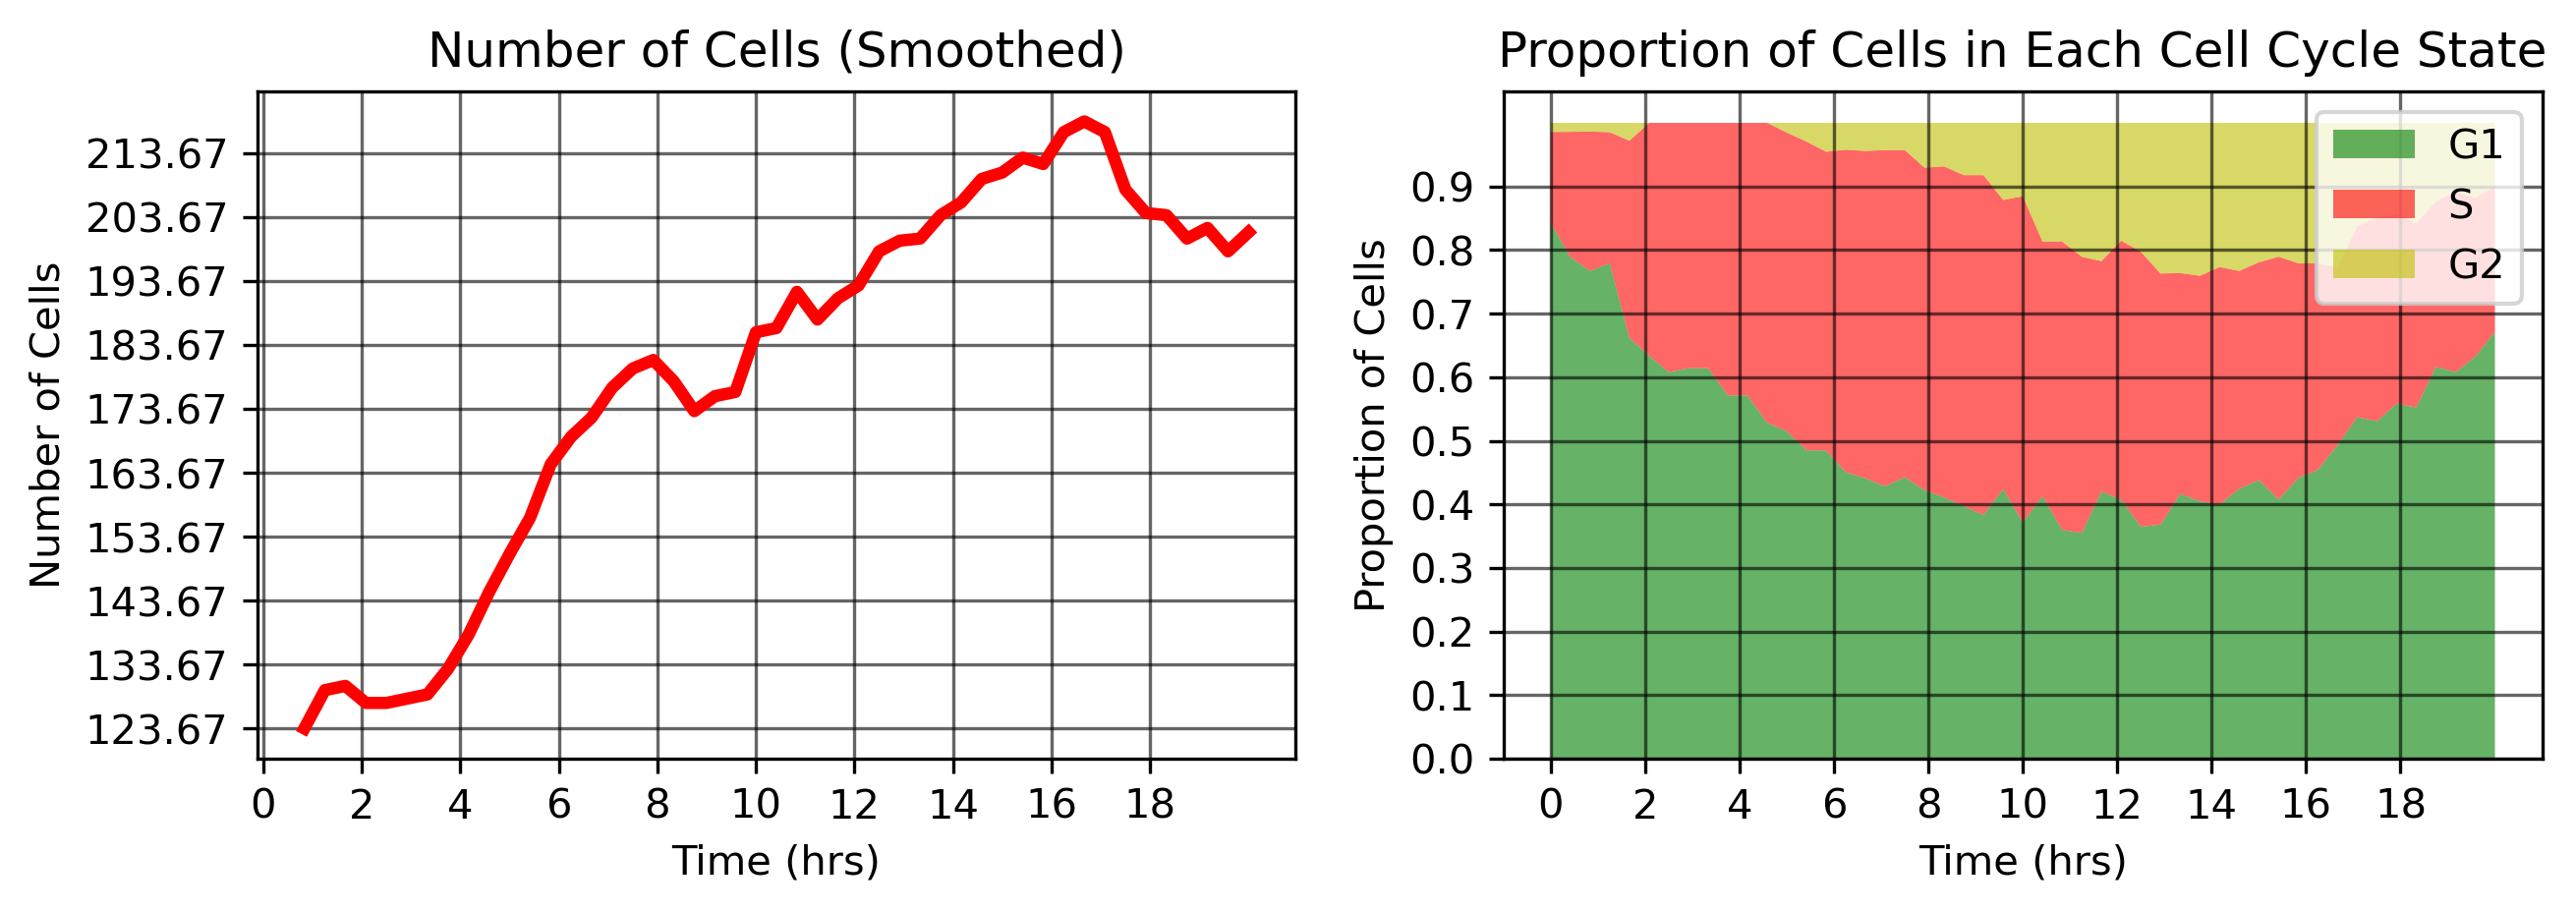

In [18]:

plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 300
fig, (ax1, ax2) = plt.subplots(1, 2)


grped['MA'] = grped['total_all'].rolling(window=3).mean()

ax1.plot(grped['Time'], grped['MA'], c='r', ls='-', lw=3)
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Number of Cells")
ax1.set_title(f"Number of Cells (Smoothed)")

ax1.set_xticks(np.arange(0, grped['Time'].max(), 2))
ax1.set_yticks(np.arange(grped['MA'].min(), grped['MA'].max(), 10))
ax1.grid(color='k', alpha=0.6)

stack = [grped['pG1'], grped['pS'], grped['pG2']]
ax2.stackplot(grped['Time'], stack, 
              labels=['G1','S','G2'], 
              colors=['g', 'r', 'y'],
              alpha=0.6)

ax2.set_xticks(np.arange(0, grped['Time'].max(), 2))
ax2.set_yticks(np.arange(0, 1., 0.1))
ax2.grid(color='k', alpha=0.6)
ax2.legend(loc='upper right')
ax2.set_title(f"Proportion of Cells in Each Cell Cycle State")
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Proportion of Cells")


Text(0, 0.5, 'Percent of Cells')

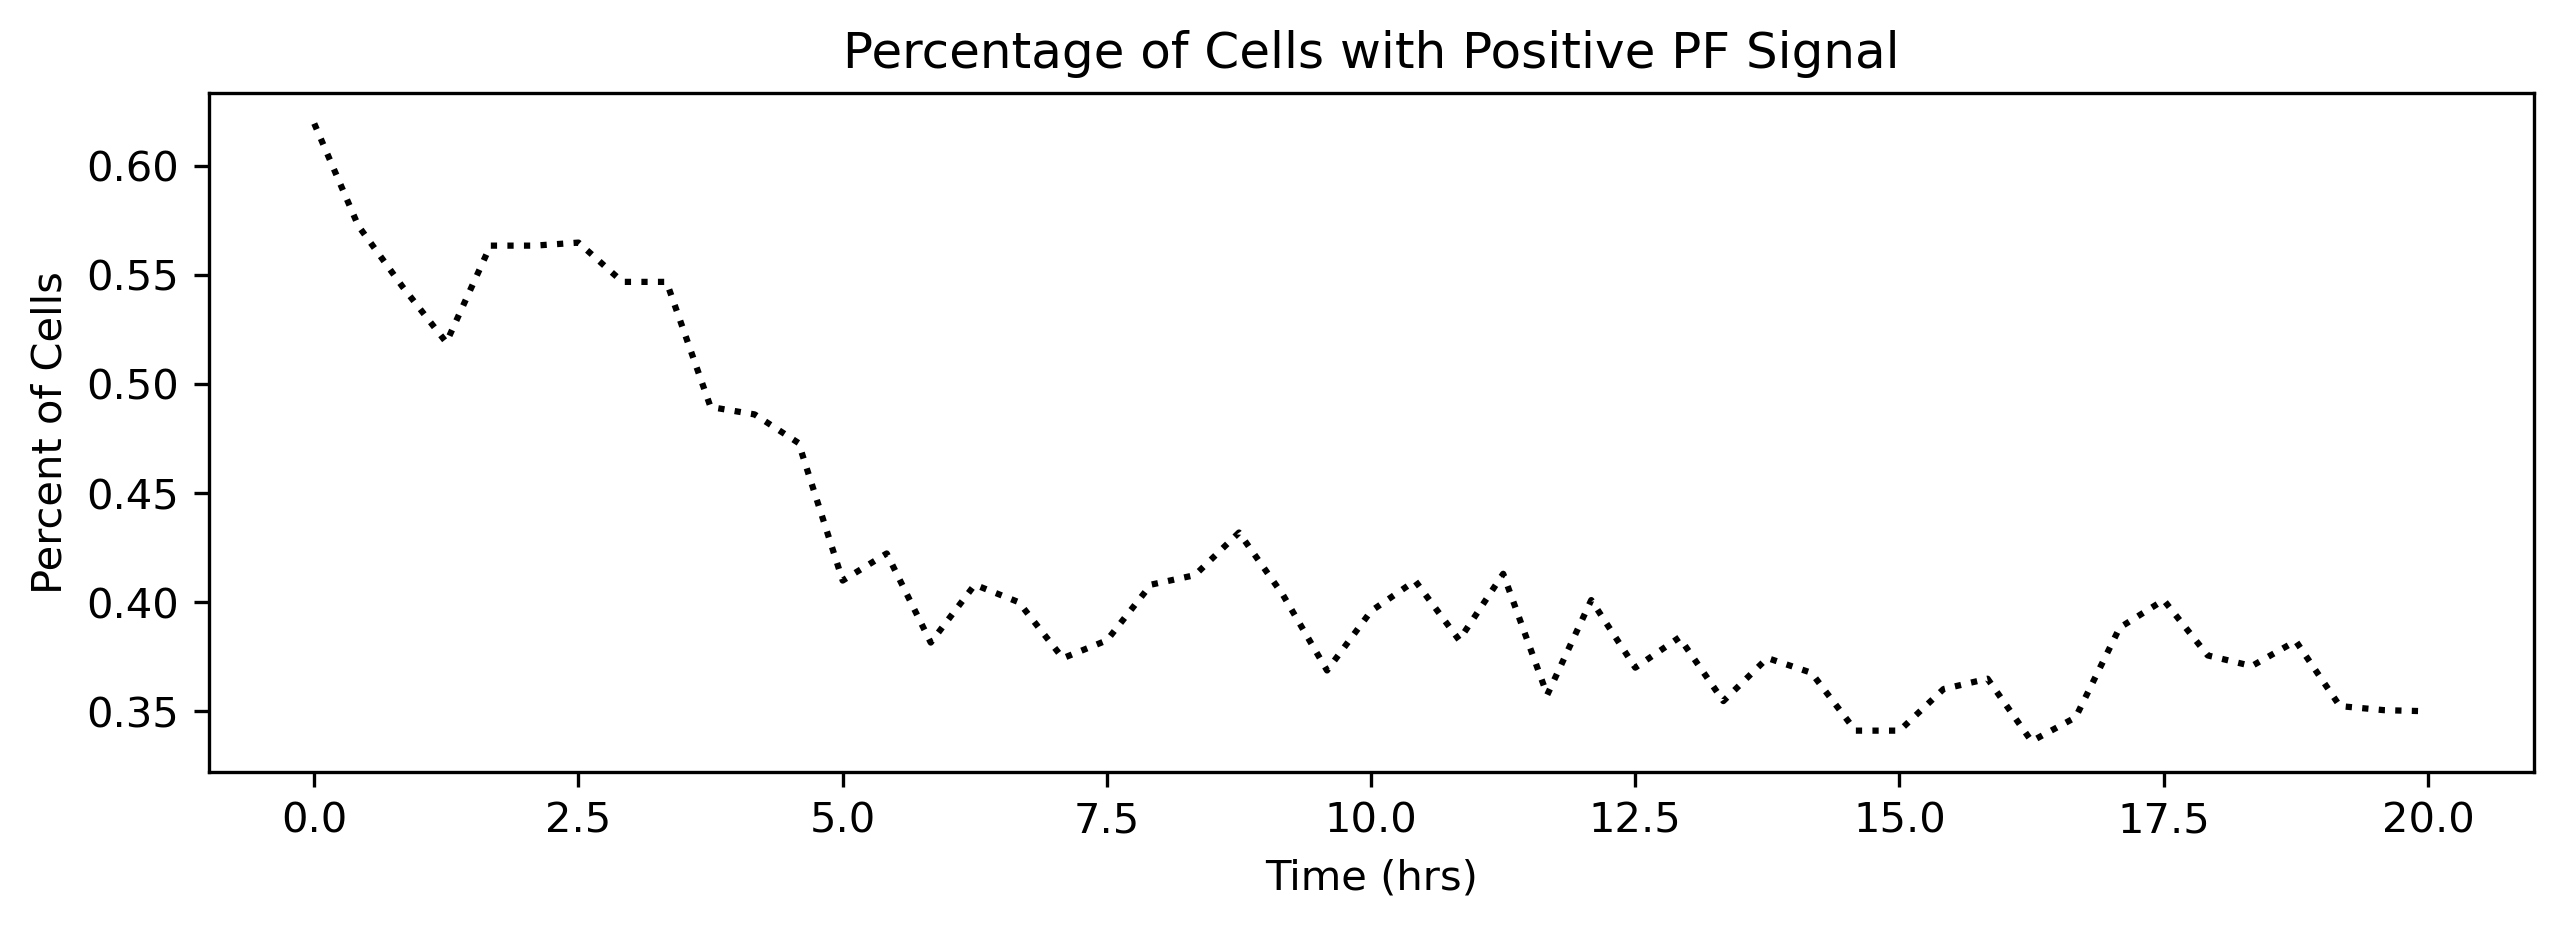

In [19]:
grped['pPF'] = grped['total'] / grped['total_all']

plt.plot(grped['Time'], grped['pPF'], c='k', ls=':')

plt.title(f"Percentage of Cells with Positive PF Signal")
plt.xlabel("Time (hrs)")
plt.ylabel("Percent of Cells")

int(rand_tid)=140
tmp.shape=(43, 55)


Text(61.583333333333336, 0.5, 'Estimated Cell Phase')

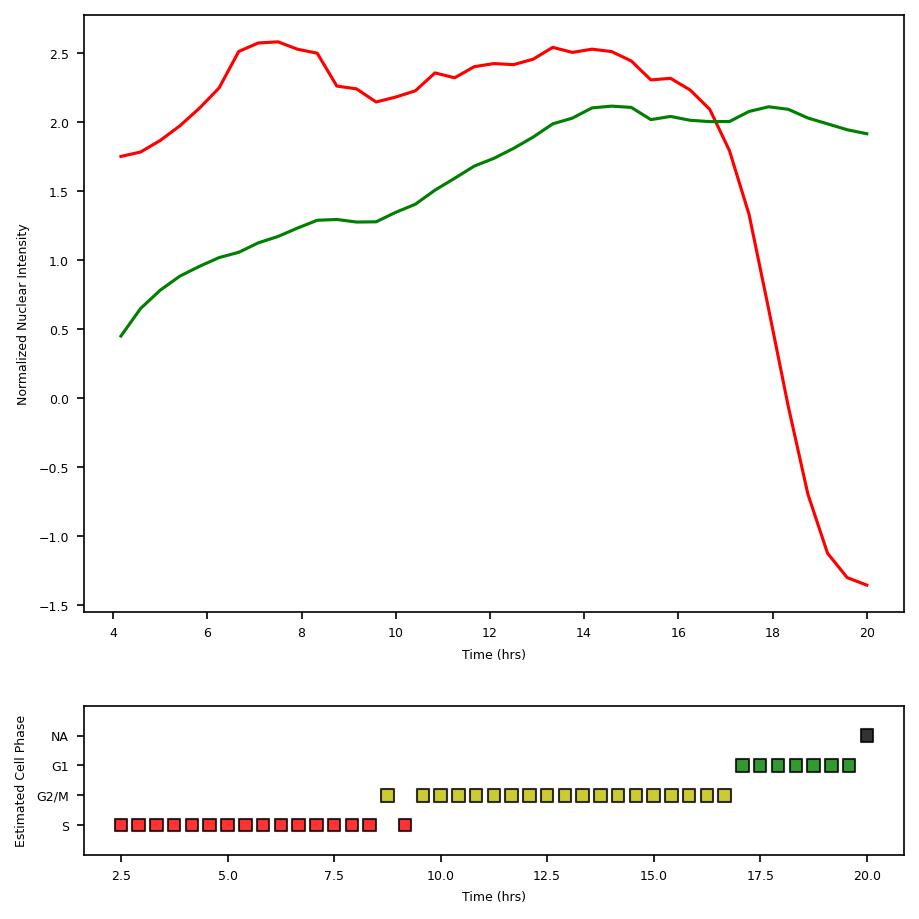

In [20]:
# visual a single track predictions

df['STEP'] = df.groupby(['TRACK_ID']).cumcount()
df['MAXSTEP'] = df.groupby(['TRACK_ID'])['FRAME'].transform("count")
df['Time'] = (df['FRAME'] * minutes_per_frame) / 60

long_tracks = df[df['MAXSTEP'] > 20.0]

rand_tid = np.random.choice(long_tracks['TRACK_ID'].unique(), 1)[0]
print(f"{int(rand_tid)=}")

tmp = df[df['TRACK_ID'] == rand_tid]
tmp = tmp.sort_values(by='FRAME').reset_index()

print(f"{tmp.shape=}")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = 6, 6

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.25)

tmp['smooth_red'] = tmp['SNR_RED'].rolling(window=5).mean()
tmp['smooth_green'] = tmp['SNR_GREEN'].rolling(window=5).mean()

ax1.plot(tmp['Time'], tmp['smooth_red'], c='r')
ax1.plot(tmp['Time'], tmp['smooth_green'], c='g')
# ax1.set_title("PIP-FUCCI Reporter Signal Over Time")
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Normalized Nuclear Intensity")

colors = {
    'G1':'g', 
    'S':'r', 
    'G2/M':'y', 
    'NA' : 'k'
 }

ax2.scatter(tmp['Time'], 
            tmp['estimate'], 
            c = tmp['estimate'].map(colors), 
            marker="s",
            edgecolor='k',
            alpha=0.8)
n_states =  tmp['estimate'].nunique()
ax2.set_ylim(-1, n_states)
# ax2.set_title("Estimated Cell Phase")
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Estimated Cell Phase")